In [1]:
import os
import torch
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np


In [2]:
# device = torch.device('mps')
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
# class CVAE(nn.Module):
#     def __init__(self, input_dim, label_dim, hidden_dim, latent_dim):
#         super(CVAE, self).__init__()
        
#         self.encoder = nn.Sequential(
#             nn.Linear(input_dim + label_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, latent_dim * 2)  # 输出均值和方差
#         )
        
#         self.decoder = nn.Sequential(
#             nn.Linear(latent_dim + label_dim, hidden_dim),
#             nn.ReLU(),
#             nn.Linear(hidden_dim, input_dim),
#             nn.Sigmoid()  # 输出的像素值在[0, 1]之间
#         )
    
#     def reparameterize(self, mu, logvar):
#         std = torch.exp(0.5 * logvar)
#         eps = torch.randn_like(std)
#         return mu + eps * std
    
#     def forward(self, x, label):
#         combined_input = torch.cat([x, label], dim=1)
#         mu, logvar = self.encoder(combined_input).chunk(2, dim=1)
#         z = self.reparameterize(mu, logvar)
#         return self.decoder(torch.cat([z, label], dim=1)), mu, logvar
    
# # class CVAE(nn.Module):
# #     def __init__(self, input_dim, label_dim, hidden_dim, latent_dim, init_temperature, anneal_rate):
# #         super(CVAE, self).__init__()
        
# #         self.encoder = nn.Sequential(
# #             nn.Linear(input_dim + label_dim, hidden_dim),
# #             nn.ReLU(),
# #             nn.Linear(hidden_dim, latent_dim * 2)  # 输出均值和方差
# #         )
        
# #         self.decoder = nn.Sequential(
# #             nn.Linear(latent_dim + label_dim, hidden_dim),  # 确保这里的输入大小是latent_dim + label_dim
# #             nn.ReLU(),
# #             nn.Linear(hidden_dim, input_dim),
# #             nn.Sigmoid()  # 输出的像素值在[0, 1]之间
# #         )
        
# #         self.temperature = init_temperature
# #         self.anneal_rate = anneal_rate
    
# #     def reparameterize(self, logits):
# #         # Gumbel-Softmax reparameterization
# #         gumbels = -torch.empty_like(logits).exponential_().log()  # sample from Gumbel(0, 1)
# #         y = logits + gumbels
# #         return F.softmax(y / self.temperature, dim=-1)

# #     def forward(self, x, label):
# #         combined_input = torch.cat([x, label], dim=1)
# #         logits = self.encoder(combined_input)
# #         z = self.reparameterize(logits)
# #         return self.decoder(torch.cat([z, label], dim=1)), logits

# #     def anneal_temperature(self):
# #         self.temperature *= self.anneal_rate

    
# def loss_function(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD

# def one_hot(labels, class_size):
#     targets = torch.zeros(labels.size(0), class_size)
#     for i, label in enumerate(labels):
#         targets[i, label] = 1
#     return targets

# def compute_loss(recon_x, x, mu, logvar):
#     BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
#     KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
#     return BCE + KLD, BCE, KLD

# train_losses = []
# def train(model, dataloader, optimizer, epoch, pbar):
#     model.train()
#     train_loss = 0
#     BCE_loss = 0
#     KLD_loss = 0
#     for batch_idx, (data, labels) in enumerate(dataloader):
#         data = data.view(-1, 784)  # Flatten the images
#         labels = one_hot(labels, 10)  # One hot encode the labels
#         data, labels = data.to(device), labels.to(device)
#         optimizer.zero_grad()
        
#         recon_batch, mu, logvar = model(data, labels)
#         loss, BCE, KLD = compute_loss(recon_batch, data, mu, logvar)
#         loss.backward()
#         train_loss += loss.item() / len(data)
#         BCE_loss += BCE.item() / len(data)
#         KLD_loss += KLD.item() / len(data)
#         optimizer.step()

#         train_losses.append((train_loss, BCE_loss, KLD_loss))

#         pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f}'.format(
#             epoch, batch_idx * len(data), len(dataloader.dataset),
#             100. * batch_idx / len(dataloader),
#             loss.item() / len(data),
#             )
#             )
#         pbar.update()
#     return train_loss, BCE_loss, KLD_loss

# def get_data_loader(dataset_name, transform, batch_size=1024):
#     if dataset_name == 'MNIST':
#         dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
#     elif dataset_name == 'CIFAR10':
#         dataset = datasets.CIFAR10('data', train=True, download=True, transform=transform)
#     # add other datasets as needed
#     else:
#         raise ValueError('Invalid dataset name')

#     dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
#     return dataloader

# def generate_digit(model, z, label):
#     # model: trained model
#     # z: latent variable, torch.Tensor of shape (latent_dim,)
#     # label: class label, integer

#     # Perform one-hot encoding on the label
#     label_onehot = torch.zeros(10).to(z.device)  # Assuming there are 10 classes
#     label_onehot[label] = 1.

#     # Concatenate z and label
#     z_and_label = torch.cat([z, label_onehot])

#     # Pass through the decoder
#     digit = model.decoder(z_and_label)

#     # Reshape and visualize the digit
#     digit_reshaped = digit.view(28, 28).detach().cpu()
#     plt.imshow(digit_reshaped, cmap='gray')
#     # plt.show()
#     return digit_reshaped



In [4]:
# # Run the main function on MNIST
# input_dim = 784  # 28*28, size of MNIST images
# label_dim = 10  # Number of classes in MNIST
# hidden_dim = 400
# latent_dim = 10

# # Initialize the model and optimizer
# model = CVAE(input_dim, label_dim, hidden_dim, latent_dim).to(device)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)

# def main(dataset_name):
#     # Prepare the data
#     transform = transforms.ToTensor()
#     dataloader = get_data_loader(dataset_name, transform)
#     epochs = 100

#     pbar = tqdm(total=epochs*len(dataloader))
#     for epoch in range(1, epochs + 1):
#         train(model, dataloader, optimizer, epoch, pbar)
#     pbar.close()

# main('MNIST')

In [5]:
class CVAE(nn.Module):
    def __init__(self, input_dim, label_dim, hidden_dim, latent_dim, init_temperature, anneal_rate):
        super(CVAE, self).__init__()
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dim + label_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim)  # 输出logits
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim + label_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, input_dim),
            nn.Sigmoid()
        )
        self.latent_dim = latent_dim
        self.temperature = init_temperature
        self.anneal_rate = anneal_rate
    
    def reparameterize(self, logits):
        # Gumbel-Softmax reparameterization
        gumbels = -torch.empty_like(logits).exponential_().log()
        y = logits + gumbels
        return F.softmax(y / self.temperature, dim=-1)

    def forward(self, x, label):
        combined_input = torch.cat([x, label], dim=1)
        logits = self.encoder(combined_input)
        z = self.reparameterize(logits)
        return self.decoder(torch.cat([z, label], dim=1)), logits

    def anneal_temperature(self):
        self.temperature *= self.anneal_rate

def compute_loss(recon_x, x, logits, latent_dim):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    q_y = F.softmax(logits, dim=-1)
    log_q_y = torch.log(q_y + 1e-20)
    KLD = torch.sum(q_y * (log_q_y - torch.log(torch.tensor(1.0 / latent_dim))), dim=-1).mean()
    return BCE + KLD, BCE, KLD


def one_hot(labels, class_size):
    targets = torch.zeros(labels.size(0), class_size)
    for i, label in enumerate(labels):
        targets[i, label] = 1
    return targets

train_losses = []

def train(model, dataloader, optimizer, epoch, pbar):
    model.train()
    train_loss = 0
    BCE_loss = 0
    KLD_loss = 0
    for batch_idx, (data, labels) in enumerate(dataloader):
        data = data.view(-1, 784)  # Flatten the images
        labels = one_hot(labels, 10)  # One hot encode the labels
        data, labels = data.to(device), labels.to(device)
        optimizer.zero_grad()
        
        recon_batch, logits = model(data, labels)
        loss, BCE, KLD = compute_loss(recon_batch, data, logits, model.latent_dim)
        loss.backward()
        train_loss += loss.item() / len(data)
        BCE_loss += BCE.item() / len(data)
        KLD_loss += KLD.item() / len(data)
        optimizer.step()

        train_losses.append((train_loss, BCE_loss, KLD_loss))

        pbar.set_description('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.3f} Temp: {:.3f}'.format(
            epoch, batch_idx * len(data), len(dataloader.dataset),
            100. * batch_idx / len(dataloader),
            loss.item() / len(data),
            model.temperature
            )
            )
        pbar.update()
    return train_loss, BCE_loss, KLD_loss

def get_data_loader(dataset_name, transform, batch_size):
    if dataset_name == 'MNIST':
        dataset = datasets.MNIST('data', train=True, download=True, transform=transform)
    elif dataset_name == 'CIFAR10':
        dataset = datasets.CIFAR10('data', train=True, download=True, transform=transform)
    elif dataset_name == 'EMNIST':
        dataset = datasets.EMNIST('data', train=True, download=True, transform=transform)
    elif dataset_name == 'FashionMNIST':
        dataset = datasets.FashionMNIST('data', train=True, download=True, transform=transform)
    # ...
    else:
        raise ValueError('Invalid dataset name')

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    return dataloader

def generate_digit(model, z, label):
    # model: trained model
    # z: latent variable, torch.Tensor of shape (latent_dim,)
    # label: class label, integer

    # Perform one-hot encoding on the label
    label_onehot = torch.zeros(10).to(z.device)  # Assuming there are 10 classes
    label_onehot[label] = 1.

    # Concatenate z and label
    z_and_label = torch.cat([z, label_onehot])

    # Pass through the decoder
    digit = model.decoder(z_and_label)

    # Reshape and visualize the digit
    digit_reshaped = digit.view(28, 28).detach().cpu()
    plt.imshow(digit_reshaped, cmap='gray')
    # plt.show()
    return digit_reshaped

def predict_label(model, data, label):
    # model: trained model
    # data: image data, torch.Tensor of shape (1, 784)
    # label: class label, integer

    # Perform one-hot encoding on the label
    label_onehot = torch.zeros(10).to(data.device)  # Assuming there are 10 classes
    label_onehot[label] = 1.

    # Pass through the encoder
    combined_input = torch.cat([data, label_onehot], dim=1)
    logits = model.encoder(combined_input)
    y = F.softmax(logits, dim=-1)
    return y

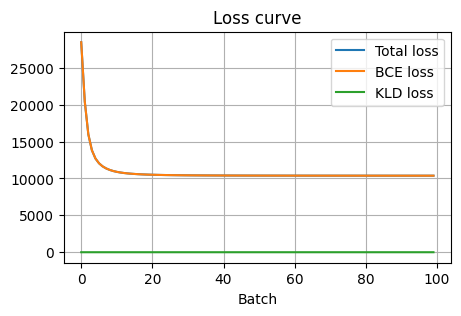

Train Epoch: 100 [59000/60000 (98%)]	Loss: 175.146 Temp: 0.990: 100%|██████████| 6000/6000 [04:52<00:00, 20.48it/s]


In [6]:
from IPython.display import clear_output

# Run the main function on MNIST
dataset_name = 'MNIST'
input_dim = 784  # 28*28, size of MNIST images
label_dim = 10  # Number of classes in MNIST
hidden_dim = 1000 # hd
latent_dim = 10
learning_rate = 1e-4 # lr
init_temperature = 0.99
anneal_rate = 1.0
epochs = 100 # ep
batch_size = 1000 # bs

# Initialize the model and optimizer
model = CVAE(input_dim, label_dim, hidden_dim, latent_dim, init_temperature, anneal_rate).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Prepare to plot the loss
losses = []
fig = plt.figure()

# Prepare the path to save the model
model_dir = 'models'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
model_path = os.path.join(model_dir, f'{dataset_name}_digit_hd{hidden_dim}_ep{epochs}_bs{batch_size}_lr{learning_rate}.pt')

def live_plot(data_dict, figsize=(5,3), title='Loss curve'):
    clear_output(wait=True)
    plt.figure(figsize=figsize)
    for label,data in data_dict.items():
        plt.plot(data, label=label)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('Batch')
    plt.legend(loc='upper right') # the plot evolves to the right
    plt.show()

def main(dataset_name):
    # Prepare the data
    transform = transforms.ToTensor()
    dataloader = get_data_loader(dataset_name, transform, batch_size)
    
    print(f'epoch: {epochs}, size of dataloader: {len(dataloader)}')
    pbar = tqdm(total=epochs*len(dataloader))
    for epoch in range(1, epochs + 1):
        total_loss, BCE_loss, KLD_loss = train(model, dataloader, optimizer, epoch, pbar)
        model.anneal_temperature()
        losses.append((total_loss, BCE_loss, KLD_loss))
        data_dict = {'Total loss': [x[0] for x in losses], 'BCE loss': [x[1] for x in losses], 'KLD loss': [x[2] for x in losses]}
        live_plot(data_dict)
    pbar.close()

    # Save the model
    torch.save(model.state_dict(), model_path)

main(dataset_name)


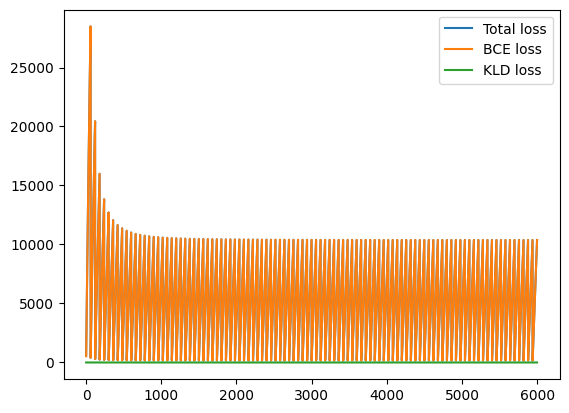

Average total loss: 5544.525
Average BCE loss: 5544.456
Average KLD loss: 0.070
Final total loss: 10378.292
Final BCE loss: 10378.155
Final KLD loss: 0.138


In [7]:
#  Plot the loss curve
plt.figure()
plt.plot([x[0] for x in train_losses], label='Total loss')
plt.plot([x[1] for x in train_losses], label='BCE loss')
plt.plot([x[2] for x in train_losses], label='KLD loss')
plt.legend()
plt.show()

# Calculate the avg losses
avg_total_loss = [x[0] for x in train_losses]
avg_BCE_loss = [x[1] for x in train_losses]
avg_KLD_loss = [x[2] for x in train_losses]
print('Average total loss: {:.3f}'.format(sum(avg_total_loss) / len(avg_total_loss)))
print('Average BCE loss: {:.3f}'.format(sum(avg_BCE_loss) / len(avg_BCE_loss)))
print('Average KLD loss: {:.3f}'.format(sum(avg_KLD_loss) / len(avg_KLD_loss)))

# Print the final loss
print('Final total loss: {:.3f}'.format(train_losses[-1][0]))
print('Final BCE loss: {:.3f}'.format(train_losses[-1][1]))
print('Final KLD loss: {:.3f}'.format(train_losses[-1][2]))


In [8]:
# # Generate 0-9 in one row
# fig, axes = plt.subplots(1, 10, figsize=(20, 2))  # Creates a grid of 10 subplots
# for i in range(10):
#     z = torch.randn(latent_dim).to(device)  # Randomly sample z from normal distribution
#     label = i  # Class label
#     digit = generate_digit(model, z, label)  # Generate a digit

#     # Reshape and visualize the digit
#     digit_reshaped = digit.view(28, 28).detach().cpu().numpy()
#     axes[i].imshow(digit_reshaped, cmap='gray')  # Display the digit in the i-th subplot
#     axes[i].set_title(f'Digit: {label}')  # Set the title of the subplot to the label
#     axes[i].axis('off')  # Remove axis

# plt.show()  # Display the full plot

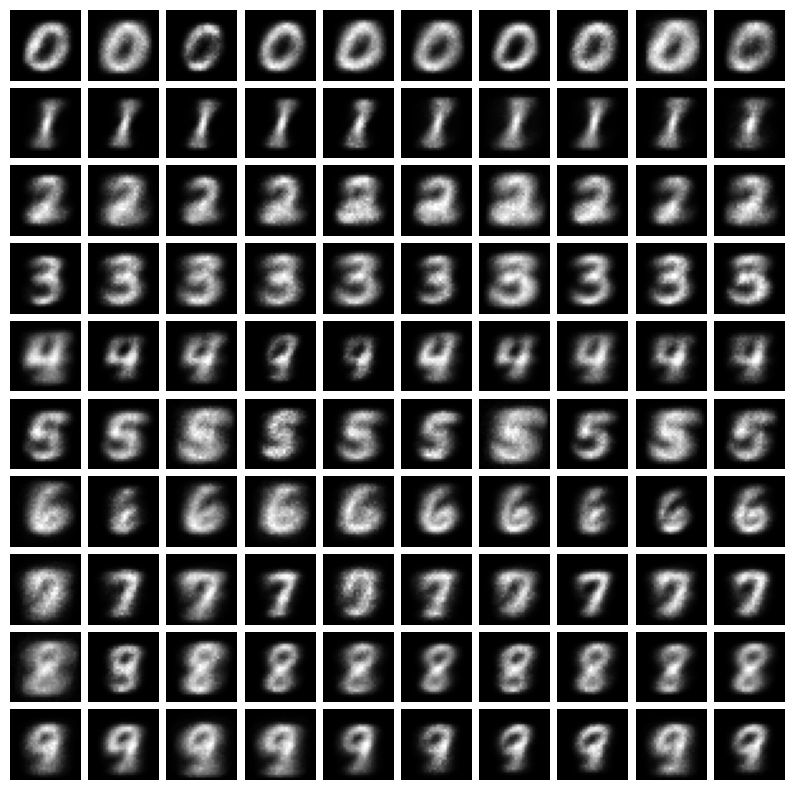

In [9]:
# # Categorize the MNIST test set into 10 lists
# transform = transforms.ToTensor()
# test_dataset = datasets.MNIST('data', train=False, download=True, transform=transform)
# test_loader = DataLoader(test_dataset, batch_size=10000, shuffle=False)

# test_data = []
# test_labels = []
# for data, labels in test_loader:
#     test_data.append(data)
#     test_labels.append(labels)
# test_data = torch.cat(test_data, dim=0)
# test_labels = torch.cat(test_labels, dim=0)

# test_data = test_data.view(-1, 784)  # Flatten the images
# test_labels = one_hot(test_labels, 10)  # One hot encode the labels

# # Compute the mean of each class
# means = []
# for i in range(10):
#     indices = (test_labels[:, i] == 1)
#     means.append(torch.mean(test_data[indices], dim=0))

# Generate 10 digits for each class
fig, axes = plt.subplots(10, 10, figsize=(10, 10))  # Creates a grid of 10 subplots
plt.subplots_adjust(wspace=0.1, hspace=0.1)  # Adjust the space between subplots
for i in range(10):
    for j in range(10):
        z = torch.randn(latent_dim).to(device)  # Randomly sample z from normal distribution
        label = i  # Class label
        digit = generate_digit(model, z, label)  # Generate a digit

        # Reshape and visualize the digit
        digit_reshaped = digit.view(28, 28).detach().cpu().numpy()
        axes[i, j].imshow(digit_reshaped, cmap='gray')  # Display the digit in the i-th subplot
        axes[i, j].axis('off')  # Remove axis
plt.show()  # Display the full plot

# Save the figure
fig_dir_name = 'logs'
if not os.path.exists(fig_dir_name):
    os.makedirs(fig_dir_name)
fig_name = f'digit_hd{hidden_dim}_ep{epochs}_bs{batch_size}.png'
fig.savefig(os.path.join(fig_dir_name, fig_name), dpi=300, bbox_inches='tight')

torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])
torch.Size([1, 1, 28, 28])


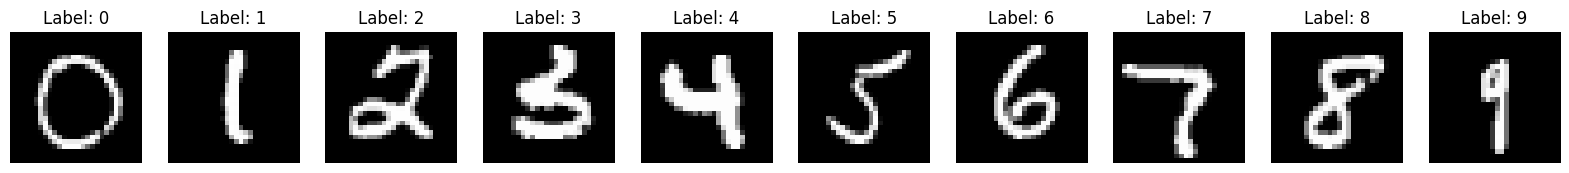

In [10]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 0. Prepare the data
transform = transforms.ToTensor()
dataloader = get_data_loader('MNIST', transform, batch_size=128)

# 1. Randomly pick one image from each class (0 - 9) as the test data
test_data = []
for i in range(10):
    for data, labels in dataloader:
        index = (labels == i).nonzero()[0]
        test_data.append((data[index], i))
        break

# 2. Show the selected images
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i, (img, label) in enumerate(test_data):
    # print(img.shape)
    axs[i].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axs[i].set_title('Label: {}'.format(label))
    axs[i].axis('off')
    print(img.shape)


Running t-SNE...
Fitting...


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


Fitting done in 124.72 seconds.


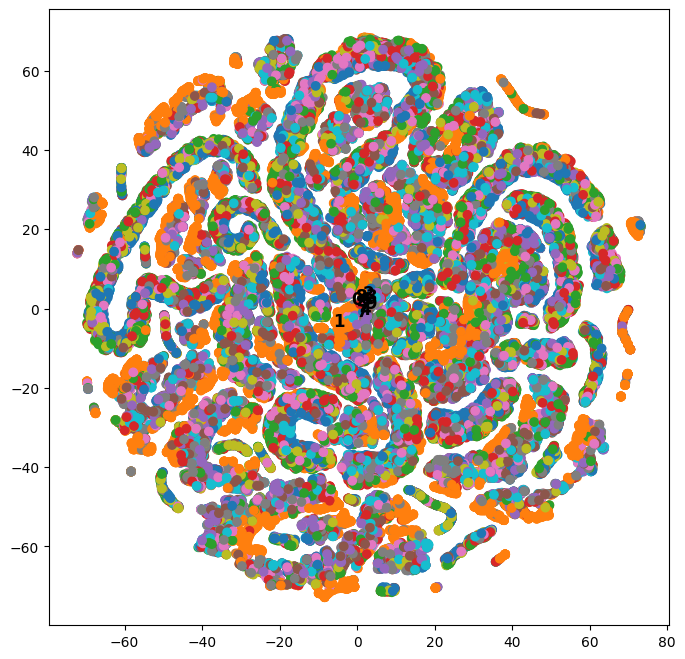

In [11]:
# T_SNE
from sklearn.manifold import TSNE
from time import time

latent_space = []
labels = []

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    for data, label in dataloader:
        data = data.view(-1, 784).to(device)  # Flatten the images
        label = one_hot(label, 10).to(device)  # One hot encode the labels
        z_logits = model.encoder(torch.cat([data, label], dim=1))  # Pass the data and labels to the encoder
        z = F.softmax(z_logits, dim=-1).cpu().numpy()  # Convert logits to probabilities and move to CPU
        latent_space.append(z)  # Append the latent variable to the list
        labels.append(label.cpu().numpy())  # Append the label to the list

# Concatenate all the latent variables and labels
latent_space = np.concatenate(latent_space, axis=0)
labels = np.concatenate(labels, axis=0)

# Use t-SNE to reduce the dimensionality of the latent space to 2D
print('Running t-SNE...')
tsne = TSNE(n_components=2, random_state=0, perplexity=10, n_iter=1000)
print('Fitting...')
start_time = time()
latent_vectors_2d = tsne.fit_transform(latent_space)
end_time = time()
print(f'Fitting done in {end_time - start_time:.2f} seconds.')

# Convert one-hot encoded labels to integer labels
labels_integer = np.argmax(labels, axis=1)

plt.figure(figsize=(8, 8))
plt.scatter(latent_vectors_2d[:, 0], latent_vectors_2d[:, 1], c=labels_integer, cmap='tab10')
for i in range(10):  # Assuming 10 different labels
    centroid = np.mean(latent_vectors_2d[labels_integer == i], axis=0)
    plt.text(centroid[0], centroid[1], str(i), color='black', fontsize=12, fontweight='bold')
plt.show()



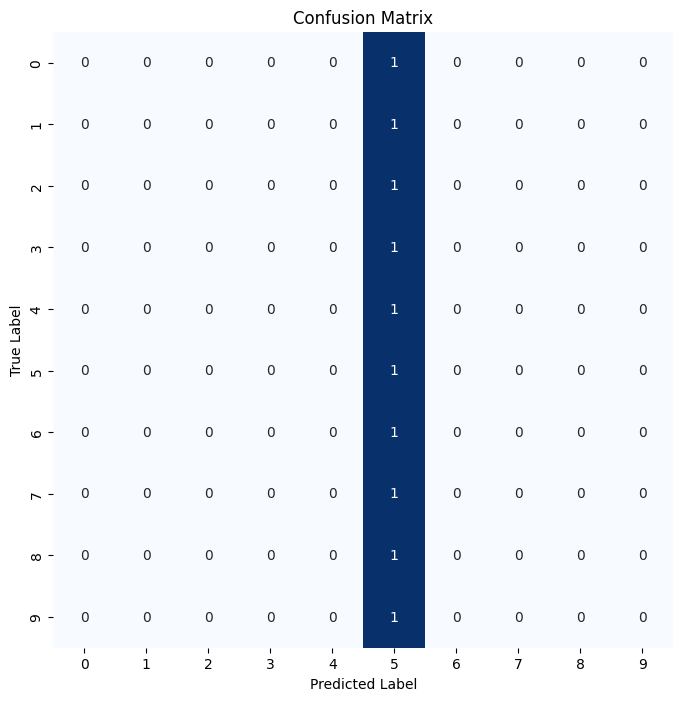

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 1. Test the model and collect predictions
# model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for img, label in test_data:
        img = img.reshape(-1, 28*28).to(device)
        label = torch.tensor(label).unsqueeze(0)
        label = one_hot(label, 10).to(device)
        z_logits, logits = model(img, label)
        predictions.append(logits.argmax(dim=-1).item())
        true_labels.append(label.argmax(dim=1).item())

# 2. Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# 3. Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()



ValueError: not enough values to unpack (expected 3, got 2)

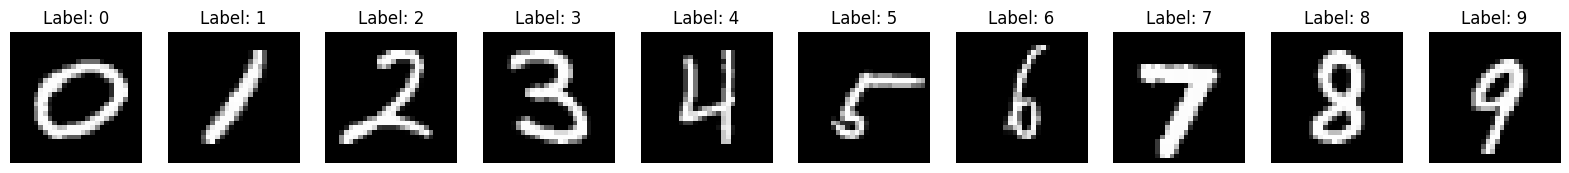

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 0. Prepare the data
transform = transforms.ToTensor()
dataloader = get_data_loader('MNIST', transform, batch_size=128)

# 1. Randomly pick one image from each class (0 - 9) as the test data
test_data = []
for i in range(10):
    for data, labels in dataloader:
        index = (labels == i).nonzero()[0]
        test_data.append((data[index], i))
        break

# 2. Show the selected images
fig, axs = plt.subplots(1, 10, figsize=(20, 2))
for i, (img, label) in enumerate(test_data):
    # print(img.shape)
    axs[i].imshow(img.squeeze().cpu().numpy(), cmap='gray')
    axs[i].set_title('Label: {}'.format(label))
    axs[i].axis('off')

# 3. Test the model and collect predictions
model.eval()
predictions = []
true_labels = []
with torch.no_grad():
    for img, label in test_data:
        img = img.reshape(-1, 28*28).to(device)
        label = torch.tensor(label).unsqueeze(0)
        label = one_hot(label, 10).to(device)
        _, _, predicted_label = model(img, label)
        predictions.append(predicted_label.argmax(dim=1).item())
        true_labels.append(label.argmax(dim=1).item())

# 4. Compute the confusion matrix
cm = confusion_matrix(true_labels, predictions)

# 5. Plot the confusion matrix
plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="binary", cbar=False)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

# 6. Calculate the rand-index
from sklearn.metrics import adjusted_rand_score
print('Rand-index: {}'.format(adjusted_rand_score(true_labels, predictions)))

